## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
col_indx = 3  #! 3 is meta.bias, 4 is meta.rbias, -1 means use meta.fbias from colvar_reweight file
data_path = "../../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"
out_dir = "./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../../run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


## load phi-psi data and bias from metad sim

In [4]:
if col_indx != -1:
    time, phi, psi, bias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,col_indx), unpack=True)
else:
    # loads the final bias 
    time, phi, psi, bias = np.loadtxt(data_path+"colvar_reweight", usecols=(0,1,2,3), unpack=True)
    bias -= bias.min()

time *= 0.001  # in ns

## plot phi-psi

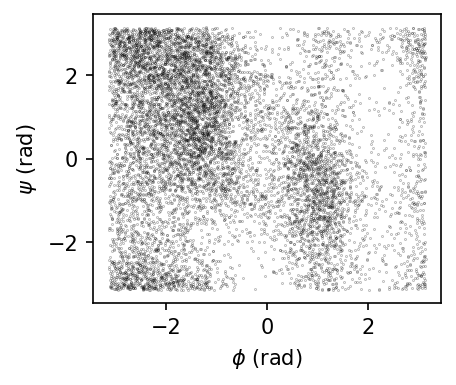

In [5]:
plt.figure(figsize=(3.0,2.5), dpi=150)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("$\psi$ (rad)")
plt.scatter(phi[::10], psi[::10], marker=".", s=0.05, color='k', alpha=1.0)

## plot different choice of metad biases

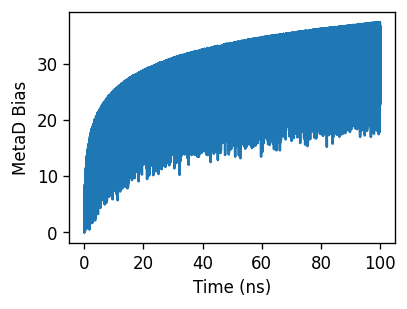

In [6]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("MetaD Bias")
plt.plot(time, bias)

## plot different weights for reweighting

In [7]:
kbt = 0.596161 # in kcal/mol @ 300K

# calculate biases
weights = np.exp(bias/kbt)
weights /= np.sum(weights)

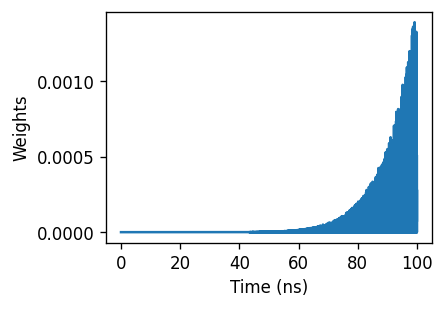

In [8]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

## define cluster array

In [9]:
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


## Perform Cross Validation

In [10]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 50000, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 50000
Number of frames to predict each model: 50001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              20.675           6.913
              1               2               1              54.859          81.008
              1               2               2              45.977         118.689
              1               2               3              54.819         117.739
              1               2               4              54.581          62.984
              1               2               5              46.368         113.543
              1               2               6              54.859          75.548
              1               2               7              44.6

              2               5               9              57.575         113.633
              2               5              10              59.417          86.914
              2               6               1              59.442         308.984
              2               6               2              57.614         160.522
              2               6               3              59.237         146.923
              2               6               4              58.507          83.766
              2               6               5              59.202         276.417
              2               6               6              57.948          58.363
              2               6               7              59.255         100.894
              2               6               8              59.603         132.000
              2               6               9              59.256         149.991
              2               6              10              59.125         

              4               4               6              58.275          56.803
              4               4               7              57.600          75.177
              4               4               8              58.418         117.097
              4               4               9              58.544          60.878
              4               4              10              58.354         238.853
              4               5               1              59.276         105.677
              4               5               2              53.880         233.466
              4               5               3              58.688          78.290
              4               5               4              59.729         275.616
              4               5               5              58.045          93.584
              4               5               6              59.663         269.632
              4               5               7              59.333         

In [10]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

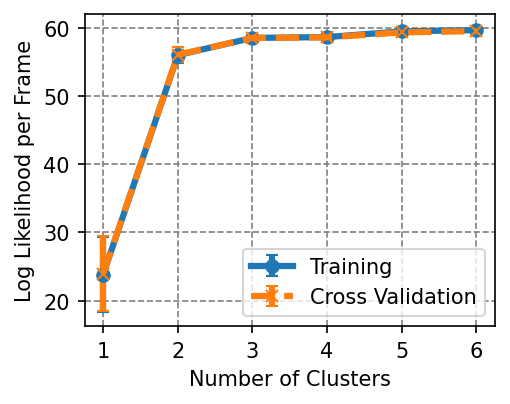

In [11]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 150, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Training")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cross Validation")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(loc="lower right")
plt.tight_layout()